Capstone 2: Horse Survival (from Kaggle)
---

The data for this project was taken from a Kaggle competition: https://www.kaggle.com/competitions/playground-series-s3e22/code?competitionId=59110&language=Python

The objective is to use a variety of binary, categorical, and numeric features to predict the survival outcome of horses. The outcome can be one of three options: survived, euthanized, or died.

Kaggle has already provided "train" and "test" datasets. In this notebook, we will take a look at the data in these sets and see if any additional wrangling needs to be done on them, as well as identify any issues we may encounter moving forward.

1. Load it up and take a peek.
---

In [1]:
# Math!
import numpy
import pandas as pd
pd.set_option('display.max_columns', None)

# Graphs!
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load up our training and test data (since we're using a Kaggle competition).
training_set = pd.read_csv('../data/raw/train.csv', index_col='id')
test_set = pd.read_csv('../data/raw/test.csv', index_col='id')

In [3]:
# Smash them together so we can clean them up at the same time
# Since 'test_set' rows will have null values for 'outcome',
# it'll be easy to sort them back out again later.
full_set = pd.concat([training_set, test_set])
print(training_set.shape)
print(test_set.shape)
print(full_set.shape)

(1235, 28)
(824, 27)
(2059, 28)


In [4]:
# Learn some basics.
full_set.info

<bound method DataFrame.info of      surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
id                                                                           
0        yes  adult           530001         38.1  132.0              24.0   
1        yes  adult           533836         37.5   88.0              12.0   
2        yes  adult           529812         38.3  120.0              28.0   
3        yes  adult          5262541         37.1   72.0              30.0   
4         no  adult          5299629         38.0   52.0              48.0   
...      ...    ...              ...          ...    ...               ...   
2054      no  adult           529461         40.3  114.0              36.0   
2055     yes  adult           535338         37.2  100.0              20.0   
2056     yes  adult           529640         39.2  132.0              12.0   
2057      no  adult          5287179         38.3   54.0              66.0   
2058     yes  adult           52

In [5]:
# And see if our labels have enough variation.

full_set['outcome'].value_counts()

lived         574
died          410
euthanized    251
Name: outcome, dtype: int64

2. Determine Feature Types
---

In [6]:
# It looks like we have a mixture of numeric and categorical variables.
# Let's split them up and deal with them differently.

numerical_features = []
categorical_features = []

# We can tell if a feature is probably categorical if it has a relatively
# small number of potential values.
for column in full_set :
    if len(full_set[column].value_counts()) > 10 :
        numerical_features.append(column)
    else :
        categorical_features.append(column)

print("Numerical features: "+str(len(numerical_features)))
print(numerical_features)
print('')
print('Categorical features: '+str(len(categorical_features)))
print(categorical_features)


Numerical features: 9
['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1']

Categorical features: 19
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'lesion_2', 'lesion_3', 'cp_data', 'outcome']


In [7]:
# Three odd things. First, 'outcome' is not a feature, so let's drop it from the list.
categorical_features.pop(-1)
print(categorical_features)


['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'lesion_2', 'lesion_3', 'cp_data']


In [8]:
# Second, "hospital_number" should probably be categorical.
# It's in the zeroth position, so:
categorical_features.append(numerical_features.pop(0))

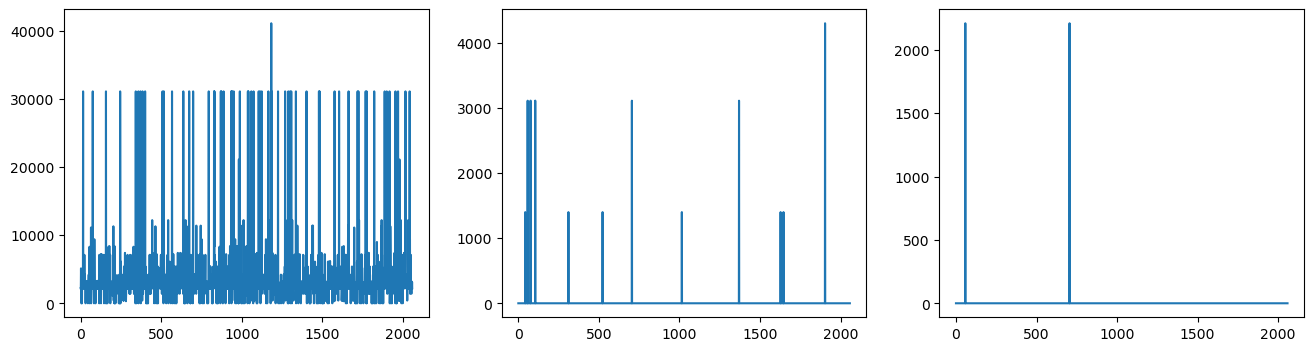

In [9]:
# Third, "lesion_1" registered as "numerical" while "lesion_2" and "lesion_3" registered as categorical.
# Let's see what's up with that...

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(full_set['lesion_1'])
ax[1].plot(full_set['lesion_2'])
ax[2].plot(full_set['lesion_3'])

plt.show()

In [10]:
# Those are some seriously weird values. Perhaps they're
# essentially categorical?
for i in range(1,4) :
    column = 'lesion_'+str(i)
    print(column+"'s nonzero count: "+str(len(full_set[full_set[column] != 0])))
    print(column+"'s unique count: "+str(len(full_set[column].unique())))
    print('')

lesion_1's nonzero count: 1906
lesion_1's unique count: 61

lesion_2's nonzero count: 12
lesion_2's unique count: 5

lesion_3's nonzero count: 2
lesion_3's unique count: 2



In [11]:
# Kind of hard to say, but it looks more categorical than not. Let's adjust.
numerical_features.remove('lesion_1')
categorical_features.append('lesion_1')


3. Examine Numerical Features
---

In [12]:
# Let's get a feel for them.
full_set[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
rectal_temp,2059.0,38.219136,0.787378,35.4,37.8,38.2,38.6,40.8
pulse,2059.0,79.836328,29.125777,30.0,54.0,76.0,100.0,184.0
respiratory_rate,2059.0,30.320544,16.849999,8.0,18.0,28.0,36.0,96.0
nasogastric_reflux_ph,2059.0,4.432977,1.916504,1.0,2.0,4.5,6.2,7.5
packed_cell_volume,2059.0,49.386693,10.502382,23.0,43.0,48.0,56.0,75.0
total_protein,2059.0,21.151190,26.566720,3.5,6.6,7.5,9.0,89.0
abdomo_protein,2059.0,3.309136,1.569174,0.1,2.0,3.2,4.3,10.1


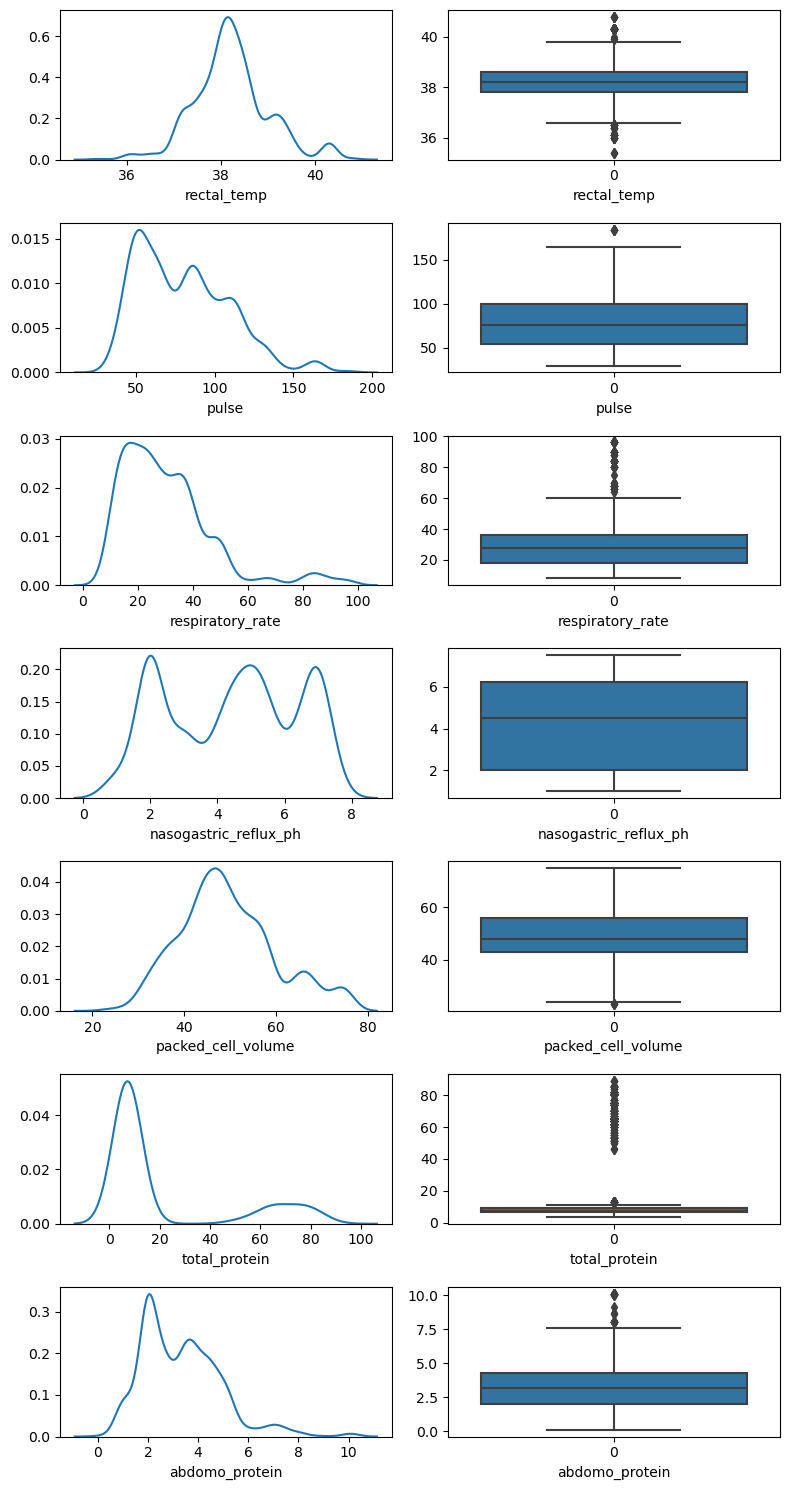

In [13]:
# Nothing too scary. Let's visualize.
# We can do KDEs and boxplots at the same time.

# Create our vessel...
fig, ax = plt.subplots(7, 2, figsize=(8, 15))

# Loop through all numerical features.
# Each row of charts will correspond to a single variable.
for i in range(len(numerical_features)) :
    # Put KDEs on the left of each row.
    sns.kdeplot(full_set[numerical_features[i]], ax=ax[i, 0])
    # Put boxplots on the right.
    sns.boxplot(full_set[numerical_features[i]], ax=ax[i, 1])
    # Delete the weird default y axis label.
    ax[i, 0].set_ylabel('')
    ax[i, 1].set_ylabel('')
    # Fix the default x label for boxplots.
    ax[i, 1].set_xlabel(numerical_features[i])

# Tidy tidy.
plt.tight_layout()
plt.show()

Nothing looks terrible here. They all seem to have reasonable distributions, some of them deliciously multimodal. No serious outliers or anomalies to contend with.

4. Examine Categorical Features
---

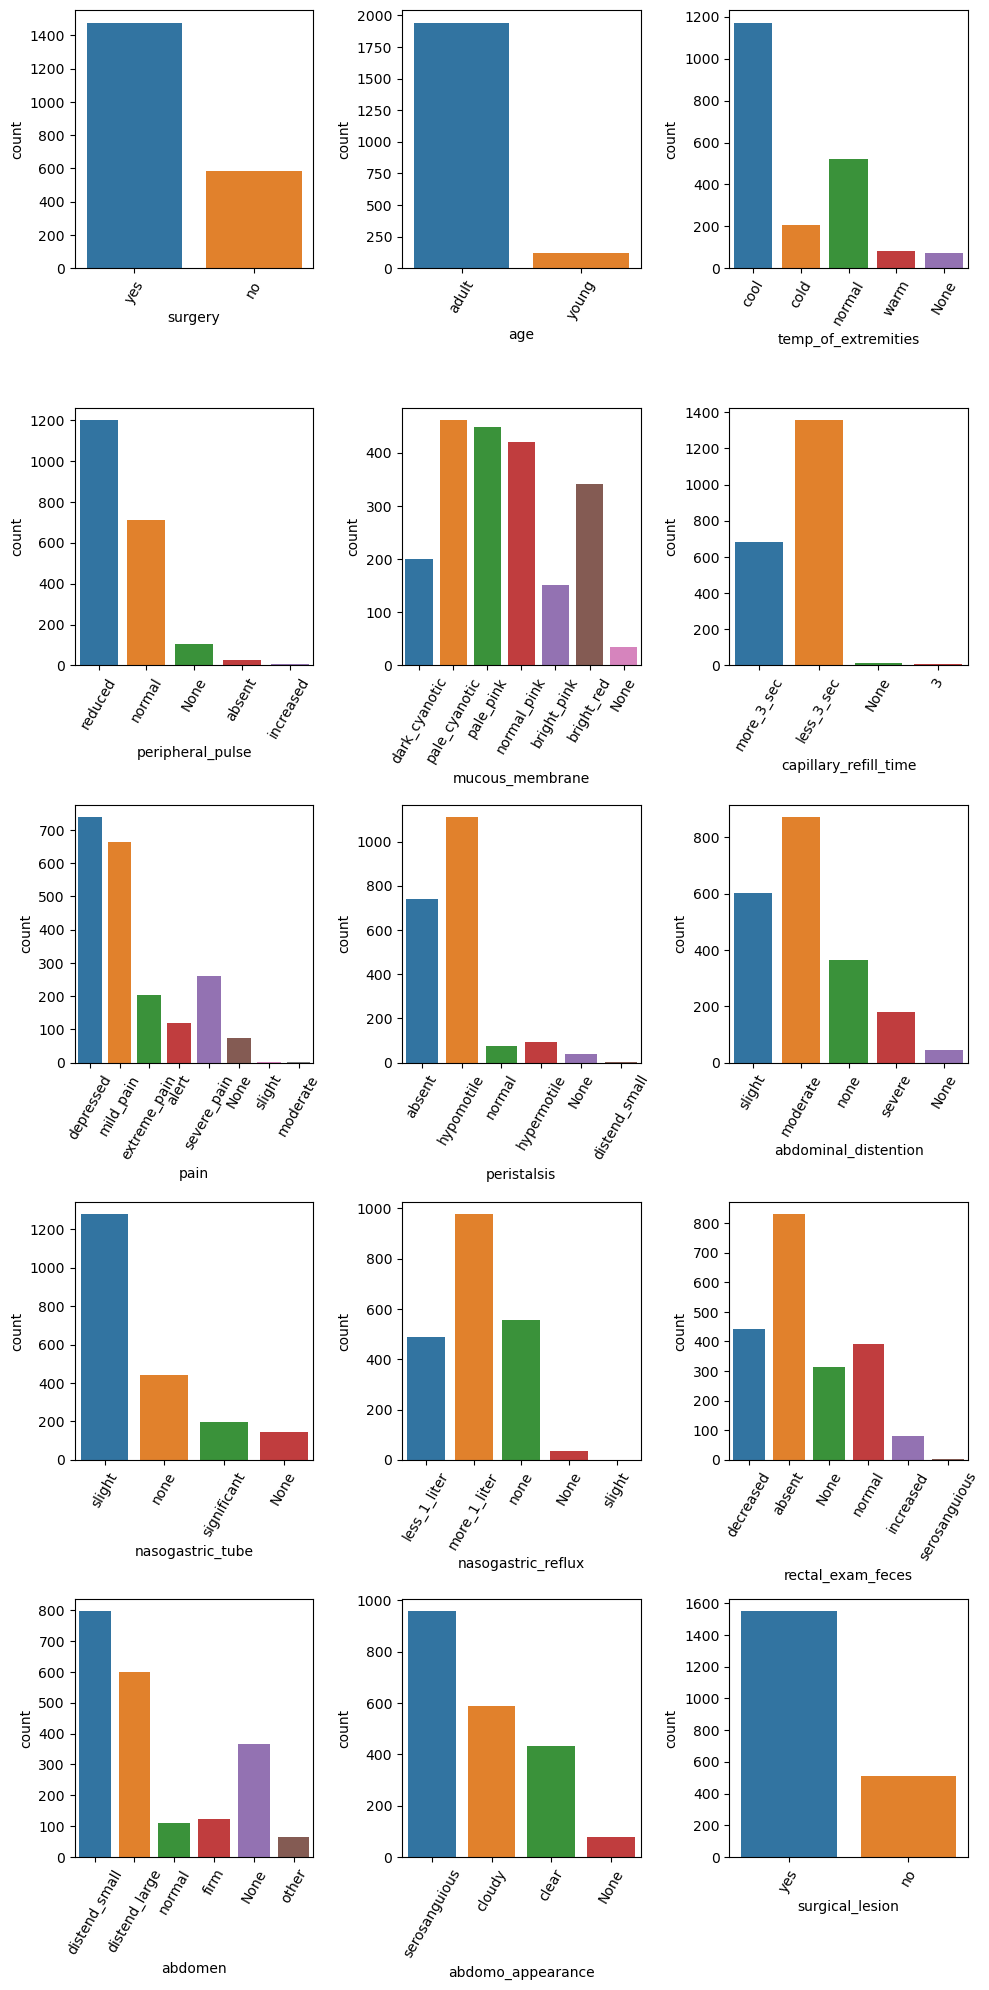

In [14]:
# First, let's look at all the unique values and see if they're sane.
# We'll excuse the 3 "lesions" and "hospital_number" from the room for now.
sane_categorical_features = categorical_features[0:15].copy()

# We can see the unique values in each categorical feature and also
# get a feel for their relative counts at the same time by just
# plotting them out with countplots.
fig, ax = plt.subplots(5, 3, figsize = (10, 20))
ax = ax.flatten()

for i in range(len(sane_categorical_features)) :
    sns.countplot(x=full_set[sane_categorical_features[i]], ax=ax[i])
    # Since our info is dense here, let's give ourselves space to breathe.
    ax[i].tick_params(axis='x', rotation=60)

# Tidy tidy.
plt.tight_layout()
plt.show()

Only a few issues here:

1. peripheral_pulse only has a few "increased" values, which may belong to the 'rectal_exam_feces' column.
2. capillary_refill_time has few '3's.
3. pain only has few 'slight's and 'moderate's, which may belong to the 'abdominal_distention' column.
4. peristalsis has few 'distend_small's, which may belong to the 'abodmen' column.
5. nasogastric_reflux has few 'slight's, which may belong to the 'nasogastric_tube' column.
6. rectal_exam_feces has few 'serosanguious's, which may belong to the 'abdomo_appearance' column.

Let's address them one by one...

In [15]:
# 1. peripheral_pulse only has a few "increased" values, which may belong to the 'rectal_exam_feces' column.

# Let's take a look.
# How many are there?
len(full_set[full_set['peripheral_pulse'] == 'increased'])

8

In [16]:
# Let's print the content of these four rows in a human-readable way.
subset = full_set[full_set['peripheral_pulse'] == 'increased']

subset

# Since the 'rectal_exam_feces' values for these are all NOT 'increased',
# it's hard to imagine that it's just a data entry error. Also, since
# 'increased' fits with the sequence of the other values in the feature,
# I will assume that it's a correct but rare situation.

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
184,no,adult,528996,38.8,52.0,20.0,warm,increased,normal_pink,less_3_sec,alert,normal,slight,significant,None,7.0,normal,None,33.0,6.5,cloudy,5.3,no,0,0,0,yes,lived
280,no,young,535043,38.4,56.0,68.0,warm,increased,normal_pink,less_3_sec,depressed,hypomotile,none,significant,none,7.0,decreased,None,41.0,77.0,clear,1.0,no,4300,0,0,no,lived
617,yes,adult,529183,38.3,60.0,28.0,normal,increased,normal_pink,less_3_sec,mild_pain,hypomotile,moderate,slight,less_1_liter,4.5,decreased,distend_small,40.0,4.5,cloudy,2.0,yes,3111,0,0,yes,lived
653,yes,adult,529493,38.3,54.0,10.0,normal,increased,pale_pink,less_3_sec,depressed,hypomotile,none,slight,more_1_liter,6.5,decreased,other,48.0,7.2,serosanguious,3.3,no,5400,0,0,no,died
1364,yes,adult,528890,38.6,48.0,16.0,cool,increased,pale_pink,less_3_sec,mild_pain,hypomotile,slight,slight,less_1_liter,7.0,absent,distend_small,48.0,7.5,serosanguious,7.0,yes,2205,0,0,no,NaN
1447,yes,adult,529498,38.4,114.0,36.0,cool,increased,normal_pink,more_3_sec,depressed,hypomotile,none,slight,none,3.0,None,distend_small,59.0,6.4,serosanguious,3.6,no,2124,0,0,yes,NaN
1671,no,adult,530612,38.0,44.0,14.0,normal,increased,normal_pink,less_3_sec,alert,hypermotile,None,none,less_1_liter,5.5,decreased,other,39.0,5.9,clear,7.0,no,3111,0,0,yes,NaN
1949,yes,adult,530034,37.8,72.0,32.0,normal,increased,bright_pink,less_3_sec,severe_pain,normal,none,slight,less_1_liter,6.0,normal,firm,46.0,5.3,clear,5.0,no,5400,0,0,no,NaN


In [17]:
# 2. capillary_refill_time has few '3's.

# Let's take a look...
full_set[full_set['capillary_refill_time'] == '3']

# There doesn't seem to be a smoking gun here.
# It clearly fits between the other values in the feature,
# so let's leave it for now...
# and revisit this during EDA and/or feature engineering.

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
97,yes,adult,5290759,37.7,76.0,20.0,cool,reduced,pale_cyanotic,3,extreme_pain,hypomotile,moderate,significant,none,3.0,absent,distend_large,53.0,6.5,serosanguious,3.9,yes,3205,0,0,no,lived
1125,no,adult,534519,37.1,84.0,30.0,cool,reduced,pale_pink,3,mild_pain,absent,moderate,significant,less_1_liter,2.0,absent,distend_large,75.0,81.0,cloudy,1.0,yes,1400,0,0,no,euthanized
1579,no,adult,528742,37.8,48.0,30.0,normal,normal,pale_pink,3,None,hypermotile,none,none,more_1_liter,5.0,normal,firm,48.0,7.2,cloudy,4.1,no,400,0,0,yes,NaN
1840,no,adult,529498,38.3,88.0,18.0,cool,reduced,pale_cyanotic,3,depressed,absent,slight,slight,less_1_liter,4.5,absent,distend_large,55.0,8.1,clear,5.0,no,2124,0,0,yes,NaN
1928,yes,adult,529461,38.6,52.0,18.0,normal,normal,pale_pink,3,depressed,hypomotile,none,slight,more_1_liter,4.0,normal,distend_small,39.0,8.0,cloudy,3.4,yes,2206,0,0,yes,NaN
1933,yes,adult,5299603,36.1,70.0,90.0,cool,reduced,dark_cyanotic,3,mild_pain,absent,moderate,slight,more_1_liter,6.0,None,None,58.0,8.1,serosanguious,2.9,yes,3300,0,0,yes,NaN


In [18]:
# 3. pain only has few 'slight's.

# Let's take a look...
full_set[full_set['pain'] == 'slight']

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1187,yes,adult,528904,37.5,72.0,60.0,None,normal,bright_red,less_3_sec,slight,hypomotile,none,slight,less_1_liter,5.0,absent,distend_small,48.0,8.0,serosanguious,2.3,yes,2207,0,0,no,euthanized


In [19]:
# Since there's only one instance of this, and 'slight' usually belongs to the
# 'nasogastric_tube' column, and this row's 'nasogastric_tube' value is indeed
# 'slight', I'll assume this was a data entry error and replace this 'pain'
# value with None.
full_set.loc[1187, 'pain'] = None

In [20]:
# 4. peristalsis has few 'distend_small's, which probably belong to the 'abodmen' column.

# Let's take a look...
full_set[full_set['peristalsis'] == 'distend_small']

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
676,yes,adult,535208,39.2,108.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,depressed,distend_small,moderate,significant,more_1_liter,2.0,None,distend_small,55.0,85.0,serosanguious,2.0,yes,3209,0,0,no,euthanized


In [21]:
# The 'abdomen' column there is also 'distend_small".
# I'm going to assume this is a data entry error and replace the 'peristalsis' value with 'None'.

full_set.loc[676, 'peristalsis'] = None

In [22]:
# 5. nasogastric_reflux has few 'slight's, which probably belong to the 'nasogastric_tube' column.

# Let's take a look...
full_set[full_set['nasogastric_reflux'] == 'slight']



,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67,no,adult,529160,38.4,48.0,28.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,slight,7.0,decreased,other,49.0,8.1,cloudy,1.5,no,3111,0,0,yes,lived


In [23]:
# It's suspicious that it's right next to a similarly-named column
# with a preponderance of those values. Let's assume it was an error
# and call it None.
training_set.loc[67, 'nasogastric_reflux'] = None

In [24]:
# 6. rectal_exam_feces has few 'serosanguious's, which probably belong to the 'abdomo_appearance' column.

full_set[full_set['rectal_exam_feces'] == 'serosanguious']

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
255,yes,adult,534145,35.4,52.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,depressed,hypomotile,moderate,significant,none,7.0,serosanguious,distend_small,57.0,69.0,serosanguious,2.0,yes,2124,0,0,no,lived


In [25]:
# Just like the others, this 'serosanguious' is probably a data entry error and should
# belong to the 'abdomo_appearance' column. Let's change it to None.
training_set.loc[255, 'rectal_exam_feces'] = None

5. Save and Quit
---

We sorted our variables into numeric and categorical, sanity checked them, and fielded some potential errors in the categorical variables.

There may be additional things to clear up, but we can't know for sure unless we begin the EDA, which will happen on anther day.

In [26]:
full_set.to_csv('../data/interim/1 - Data Wrangling.csv')